In [1]:
import numpy
import observations.dimensions.one.sampling as observe
import matplotlib.pyplot as plt

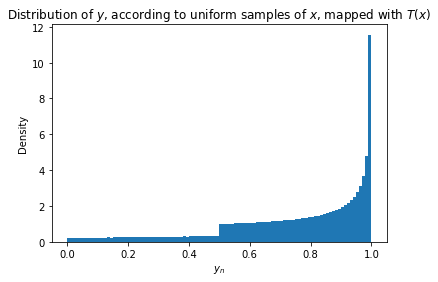

In [2]:
plt.hist(numpy.transpose(observe.sample(0))[0], bins = 100, density = True)
plt.title("Distribution of $y$, according to uniform samples of $x$, mapped with $T(x)$")
plt.xlabel("$y_n$")
plt.ylabel("Density")
plt.show()

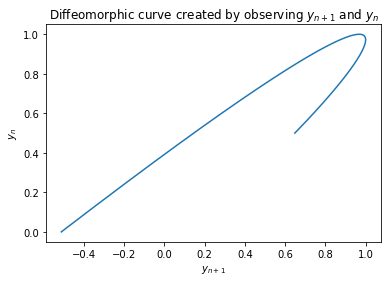

In [3]:
ys = observe.sample(1)

#plt.scatter(numpy.transpose(ys)[0], numpy.transpose(ys)[1], s = 0.5)
plt.plot(numpy.transpose(ys)[1], numpy.transpose(ys)[0])
plt.title("Diffeomorphic curve created by observing $y_{n+1}$ and $y_{n}$")
plt.xlabel('$y_{n+1}$')
plt.ylabel('$y_{n}$')
plt.show()

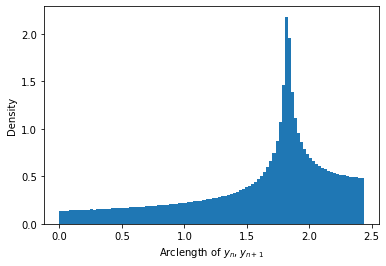

In [4]:
from observations.utils import arclen

s = arclen([numpy.transpose(ys)[0], numpy.transpose(ys)[1]])
plt.hist(s, bins=100, density=True)
plt.xlabel("Arclength of $y_{n}, y_{n+1}$")
plt.ylabel("Density")
plt.show()

In [5]:
from sklearn.preprocessing import StandardScaler
import torch
import pyro.distributions as dist

print(s)
s_normalized = StandardScaler().fit_transform([[x] for x in s])
print(s_normalized)

base_dist = dist.Normal(torch.zeros(1), torch.ones(1))
#base_dist = dist.Uniform(-10.0, 10.0)
spline_transform = dist.transforms.Spline(1, count_bins=16)
flow_dist = dist.TransformedDistribution(base_dist, [spline_transform])

steps = 1001
dataset = torch.tensor(s_normalized, dtype=torch.float)
optimizer = torch.optim.Adam(spline_transform.parameters(), lr=1e-2)
for step in range(steps):
    optimizer.zero_grad()
    loss = -flow_dist.log_prob(dataset).mean()
    loss.backward()
    optimizer.step()
    flow_dist.clear_cache()

    if step % 200 == 0:
        print('step: {}, loss: {}'.format(step, loss.item()))

[0.00000000e+00 3.65448692e-04 7.30852913e-04 ... 2.43674022e+00
 2.43684418e+00 2.43694814e+00]
[[-2.75835361]
 [-2.7577254 ]
 [-2.75709727]
 ...
 [ 1.43039214]
 [ 1.43057084]
 [ 1.43074955]]
step: 0, loss: 5.171459674835205
step: 200, loss: 1.2832438945770264
step: 400, loss: 1.1864336729049683
step: 600, loss: 1.173632025718689
step: 800, loss: 1.1685539484024048
step: 1000, loss: 1.165825366973877


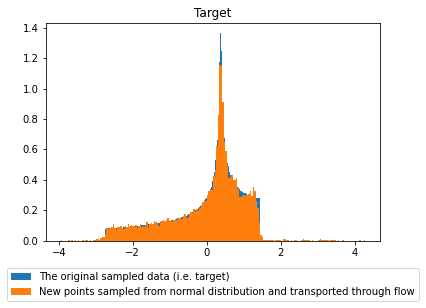

In [6]:
plt.hist(s_normalized, bins=200, density=True, label='The original sampled data (i.e. target)')
plt.hist(flow_dist.sample(torch.Size([20000])).detach().numpy(), bins=200, density=True, label='New points sampled from normal distribution and transported through flow')
plt.title('Target')
plt.legend(loc='lower center', bbox_to_anchor=(0.5, -0.3))
plt.show()

In [7]:
ys_normalized = StandardScaler().fit_transform([[y[0]] for y in ys])
print(ys_normalized)

spline_transform2 = dist.transforms.Spline(1, count_bins=16)
flow_dist_full = dist.TransformedDistribution(flow_dist, [spline_transform2])

dataset = torch.tensor(ys_normalized, dtype=torch.float)
optimizer = torch.optim.Adam(spline_transform2.parameters(), lr=1e-2)

for step in range(steps):
    optimizer.zero_grad()
    loss = -flow_dist_full.log_prob(dataset).mean()
    loss.backward()
    optimizer.step()
    flow_dist_full.clear_cache()

    if step % 200 == 0:
        print('step: {}, loss: {}'.format(step, loss.item()))

[[-3.08919274]
 [-3.08826603]
 [-3.08733944]
 ...
 [-1.02876981]
 [-1.02907874]
 [-1.02938766]]
step: 0, loss: 3.9713916778564453
step: 200, loss: 1.0238369703292847
step: 400, loss: 0.9879811406135559
step: 600, loss: 0.947211742401123
step: 800, loss: 0.9477910995483398
step: 1000, loss: 0.9382020235061646


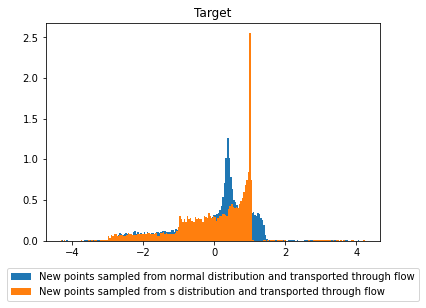

In [8]:
plt.hist(flow_dist.sample(torch.Size([20000])).detach().numpy(), bins=200, density=True, label='New points sampled from normal distribution and transported through flow')
plt.hist(flow_dist_full.sample(torch.Size([20000])).detach().numpy(), bins=200, density=True, label='New points sampled from s distribution and transported through flow')
#plt.hist(ys_normalized, bins=200, density=True, label='The original sampled data (i.e. target)')
plt.title('Target')
plt.legend(loc='lower center', bbox_to_anchor=(0.5, -0.3))
plt.show()

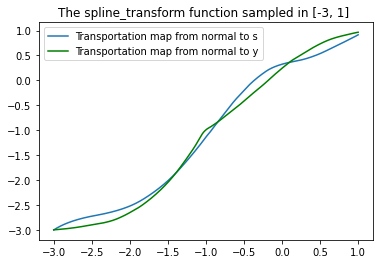

In [9]:
input = numpy.linspace(-3, 1, 10000)
mapped1 = spline_transform(torch.tensor([[x] for x in input])).detach().numpy()
mapped2 = spline_transform2(torch.tensor(mapped1)).detach().numpy()
plt.plot(input, mapped1, label="Transportation map from normal to s")
plt.plot(input, mapped2, label="Transportation map from normal to y", color="green")
plt.title("The spline_transform function sampled in [-3, 1] ")
plt.legend(loc="best")
plt.show()